In [119]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime as dt
import copy

In [120]:
quad_num = ['22', '21', '20']

In [124]:
shear_filter = pd.DataFrame()
for i in quad_num:
    print('Quad '+i)
    temp_df = pd.read_csv('/Users/samueleckford/Scripts/Shear Prediction/Shear_Log_Prediction/data/Trim/Quad' + i + '_trim.csv', index_col=0)
    shear_filter = pd.concat([shear_filter, temp_df])
    #shear_filter = shear_filter.append(temp_df, ignore_index=True)
del temp_df

Quad 22


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Quad 21
Quad 20


In [125]:
log_dict = {}
# Lists with different log name abbreviations, can be edited as needed
log_dict['GR_list'] = ['GRWS', 'gr', 'GR']
log_dict['DT_list'] = ['DTWS', 'dt', 'dtws', 'DT']
log_dict['DTS_list'] = ['DTSWS', 'DTS', 'dts', 'dtsws']
log_dict['DRes_list'] = ['DRESWS', 'DRES']
log_dict['Mres_list'] = ['MRESWS', 'MRES']
log_dict['Sres_list'] = ['SRESWS', 'SRES']
log_dict['Rhob_list'] = ['DENWS', 'RHOB', 'RHOBWS', 'RHO', 'RHOWS', 'DEN']
log_dict['Npo_list'] = ['NPOWS', 'NPO']
log_dict['Cal_list'] = ['CALWS', 'CAL', 'CALI']
log_dict['PEF_list'] = ['PEFWS', 'PEF']
log_dict['SP_list'] = ['SPWS', 'SP']

In [126]:
from Modules import column_list_merge

In [127]:
#shear_filter2 = shear_filter.copy()
column_list_merge.column_list_merge(shear_filter, log_dict)

gr column does not exist
Number of values added to GRWS column = 5209239
dt column does not exist
dtws column does not exist
Number of values added to DTWS column = 7116814
Number of values added to DTSWS column = 51904
dts column does not exist
dtsws column does not exist
Number of values added to DRESWS column = 19651
Number of values added to MRESWS column = 51136
Number of values added to SRESWS column = 7219
Number of values added to DENWS column = 2836401
RHOBWS column does not exist
RHO column does not exist
RHOWS column does not exist
Number of values added to DENWS column = 3051325
Number of values added to NPOWS column = 12412
Number of values added to CALWS column = 240179
Number of values added to CALWS column = 2329410
Number of values added to PEFWS column = 1129095
Number of values added to SPWS column = 1506717


In [128]:
shear_filter.columns = [col.replace('WS', '') for col in shear_filter.columns]
shear_filter.columns

Index(['Wellname', 'Depth', 'SP', 'GR', 'NPO', 'CAL', 'DRES', 'COND', 'MRES',
       'SRES', 'DT', 'DEN', 'PEF', 'DTS'],
      dtype='object')

In [129]:
shear_filter2 = copy.deepcopy(shear_filter)
shear_filter2['DTS'].fillna(300, inplace=True)

In [130]:
from Modules import rolling_imputer

In [131]:
### SP has a large proportion of nulls so is dropped
shear_filter.drop(['SP', 'PEF', 'SRES', 'MRES', 'NPO'], axis=1, inplace=True)
### Initially run just the DTS as this is the target log, then on all others
shear_filter = rolling_imputer.rolling_imputer(shear_filter, filter_length=200)
for i in shear_filter.columns[2:]:
    shear_filter = rolling_imputer.rolling_imputer(shear_filter, log=i, filter_length=200)
shear_filter.isna().sum()

Wellname    0
Depth       0
GR          0
CAL         0
DRES        0
COND        0
DT          0
DEN         0
DTS         0
dtype: int64

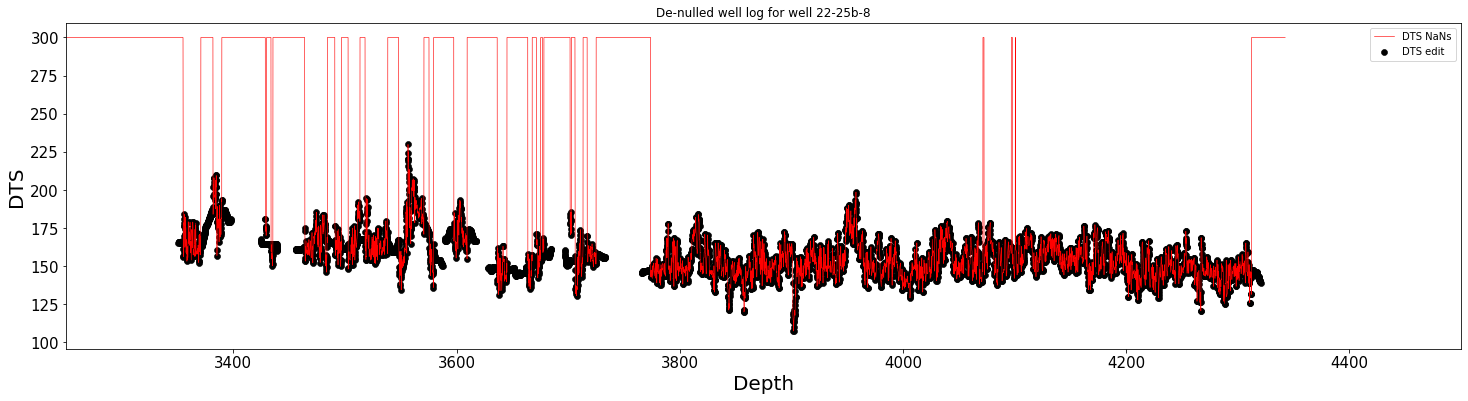

In [132]:
well = '22-25b-8'
log = 'DTS'
#for well in shear_filter2.Wellname.unique():
plt.figure(figsize=(25, 6))
plt.plot(shear_filter2[shear_filter2["Wellname"] == well]["Depth"], shear_filter2[shear_filter2["Wellname"] == well][log], linewidth=0.6, color='red', label=log + ' NaNs')
plt.scatter(shear_filter[shear_filter["Wellname"] == well]["Depth"], shear_filter[shear_filter["Wellname"] == well][log], linewidth=0.6, color='black', label=log + ' edit ')
plt.title('De-nulled well log for well ' + well)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Depth', fontsize = 20)
plt.ylabel(log, fontsize = 20)
plt.xlim(3250, 4500)
plt.legend()
plt.show()

In [133]:
well_tops_df = pd.read_csv('./data/Well_Tops/WellTops.csv', skiprows=3, header=1)
well_tops_df.head(2)

,Well,Top Paleocene,Top Chalk,Base Chalk
0,22-15-4,8214,9177,99999
1,13-22c-30,2100,2877,7997


In [134]:
shear_filter = shear_filter.merge(well_tops_df, how='left', left_on=['Wellname'], right_on=['Well'])
shear_filter['Zone'] = np.where(shear_filter.Depth<shear_filter['Top Paleocene'], 'Tertiary', 
                            np.where((shear_filter.Depth>=shear_filter['Top Paleocene'])&(shear_filter.Depth<shear_filter['Top Chalk']), 'Paleocene',
                                    np.where((shear_filter.Depth>=shear_filter['Top Chalk'])&(shear_filter.Depth<shear_filter['Base Chalk']), 'Chalk', 
                                            np.where(shear_filter.Depth>=shear_filter['Base Chalk'], 'Jurassic', np.NaN))))
# Drop values where wells don't have tops and remove extra columns
shear_filter.dropna(inplace=True)
shear_filter.drop(['Well', 'Top Paleocene', 'Top Chalk', 'Base Chalk'], axis=1, inplace=True)

In [135]:
shear_filter = pd.get_dummies(data=shear_filter, columns=["Zone"])
shear_filter.head(2)

,Wellname,Depth,GR,CAL,DRES,COND,DT,DEN,DTS,Zone_Chalk,Zone_Jurassic,Zone_Paleocene,Zone_Tertiary
0,22-6a-14Z,3852.1,22.2713,6.165,0.782710,1301.548615,94.726332,2.493329,229.495132,1,0,0,0
1,22-6a-14Z,3852.2,23.2273,6.155,0.798405,1282.381443,94.811350,2.494966,228.476719,1,0,0,0


In [136]:
well_list = list(shear_filter.Wellname.unique())
len(well_list)

30

In [143]:
#shear_filter_full = copy.deepcopy(shear_filter)
#shear_filter = shear_filter.loc[shear_filter['Zone_Paleocene']==1].copy()

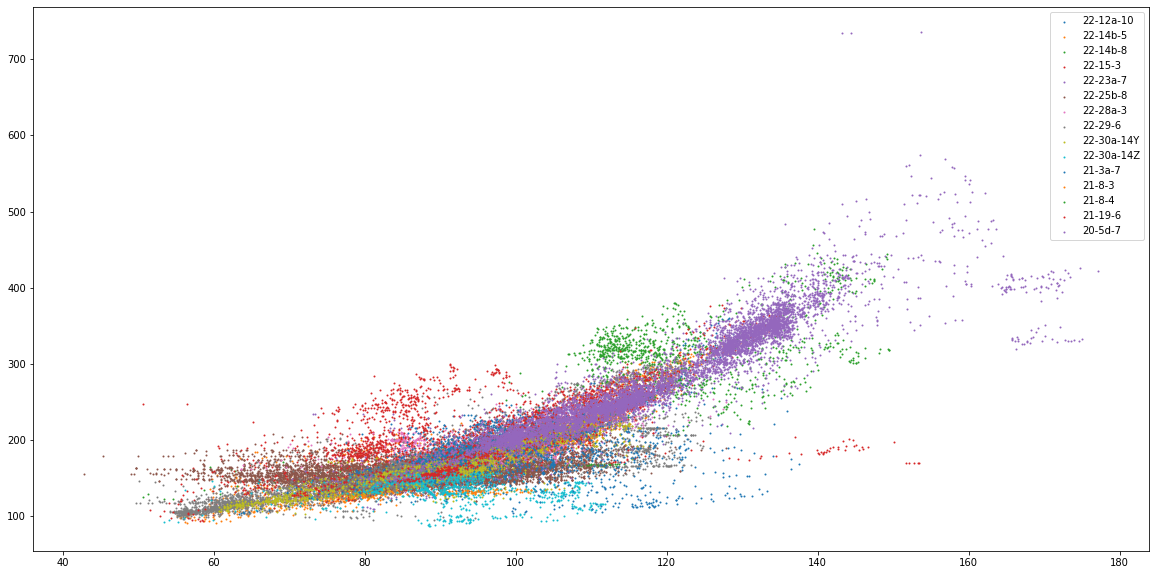

In [144]:
plt.figure(figsize=(20, 10))
for well in shear_filter.Wellname.unique():
    if well == '21-1a-19':
        continue
    plt.scatter(shear_filter.loc[(shear_filter['Wellname']==well)&(shear_filter['Zone_Paleocene']==1)]['DT'], shear_filter.loc[(shear_filter['Wellname']==well)&(shear_filter['Zone_Paleocene']==1)]['DTS'], s=1, label=well)
#well = '21-1a-19'
#plt.scatter(shear_filter.loc[shear_filter['Wellname']==well]['DT'], shear_filter.loc[shear_filter['Wellname']==well]['DTS'], s=15, label=well)
plt.legend()

In [145]:
shear_filter = shear_filter.loc[shear_filter['Wellname']!='21-1a-19']

In [146]:
shear_filter.to_csv('./data/Quads_20_21_22_Paleocene_clean.csv')

In [147]:
random.seed(38)
test_list = random.sample(well_list, int(len(well_list)*0.3))
train_list = [i for i in well_list if i not in test_list]
if '21-1a-19' in train_list: train_list.remove('21-1a-19')
if '21-1a-19' in test_list: test_list.remove('21-1a-19')
test_list

['21-8-4',
 '20-7b-5',
 '20-5c-11',
 '21-24-6',
 '22-14b-8',
 '22-14b-5',
 '22-30a-14Y',
 '21-1a-19y']

In [148]:
df_test = shear_filter[shear_filter['Wellname'].isin(test_list)]
df_train = shear_filter[~shear_filter['Wellname'].isin(test_list)]

In [149]:
folder_create = os.path.exists("data")
if folder_create is False:
    os.mkdir("./data")
    os.mkdir("./data/train")
    os.mkdir("./data/test")
folder_create = os.path.exists("./data/train")
if folder_create is False:
    os.mkdir("./data/train")
    os.mkdir("./data/test")

In [150]:
target_feature = ['DTS']
train_feature = ['GR', 'DT', 'DRES', 'DEN', 'Depth', 'COND', 'CAL', 'Zone_Tertiary', 'Zone_Paleocene', 'Zone_Chalk', 'Zone_Jurassic']

In [151]:
X_train = df_train[train_feature].copy()
X_test = df_test[train_feature].copy()

y_train = df_train[target_feature].copy()
y_test = df_test[target_feature].copy()

In [152]:
X_train.to_csv("./data/train/train_x_Paleocene_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")
y_train.to_csv("./data/train/train_y_Paleocene_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")
X_test.to_csv("./data/test/test_x_Paleocene_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")
y_test.to_csv("./data/test/test_y_Paleocene_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")